Thuật ngữ:

* Hierarchical Clustering: Phân cụm phân cấp
* centroids: tâm cụm


# 1. DBSCAN

Ở bài trước chúng ta đã làm quen với hai thuật toán quan trọng thuộc lớp bài toán học không giám sát đó là [k-Means](https://phamdinhkhanh.github.io/deepai-book/ch_ml/index_KMeans.html) và [phân cụm phân cấp (_Hierarchical Clustering_)](https://phamdinhkhanh.github.io/deepai-book/ch_ml/index_HierarchicalClustering.html). Điểm chung của những thuật toán phân cụm đều là dựa vào khoảng cách để xác định cụm cho từng quan sát, cập nhật lại cụm dần dần qua các vòng lặp.

Đối với thuật toán k-Means thì chúng ta khởi tạo ngẫu nhiên các centroids và sau đó cập nhật cụm bằng cách cập nhật lại centroids. Thuật toán _phân cụm phân cấp_ thì thực hiện liên tiếp truy hồi quá trình gộp hoặc chia cụm, toàn bộ quá trình này có thể biểu diễn thông qua một biểu đồ _dendogram_ và dựa trên biểu đồ _dendogram_ ta có thể xác định số lượng cụm phù hợp.

Nhược điểm của thuật toán _k-Means_ đó là cần phải xác định trước số lượng cụm cần phân chia, tâm của cụm sẽ bị ảnh hưởng bởi các điểm khởi tạo _tâm cụm_ (_centroids_) đầu tiên. Còn thuật toán _phân cụm phân cấp_ có chi phí tính toán lớn ($O(N^3)$, trong đó $N$ là số lượng quan sát) nên không phù hợp với những bộ dữ liệu kích thước lớn.

**So sánh giữa DBSCAN với k-Means?**

Thuật toán k-Means có thể phân cụm các quan sát có sự tương đồng một cách khá lỏng lẻo. Sau mỗi vòng lặp của thuật toán thì mỗi một quan sát đều được phân vào một cụm nhất định, thậm chí đó là những quan sát _nhiễu_ (_noise data_) phân bố cách xa tâm cụm. Do đó trong thuật toán k-Means mọi điểm đều ảnh hưởng tới tâm cụm. Chính vì điều này nên dẫn tới khi xuất hiện outliers sẽ ảnh hưởng tới độ chính xác của thuật toán cũng như chất lượng của cụm. Trong DBSCAN thì vấn đề này được khắc phục nhờ cơ chế hình thành cụm đặc biệt mà ở đó các điểm dữ liệu _nhiễu_ sẽ được tách thành một phần riêng mà chúng ta sẽ tìm hiểu cơ chế này ở phần tiếp theo. Thậm chí là đối với những phân phối có hình dạng đặc biệt mà k-Means không phân cụm tốt thì DBSCAN cũng có thể phân cụm được như hình minh hoạ bên dưới:

![](https://imgur.com/czzb7NC.png)

**Hình 1**: So sánh kết quả phân cụm giữa thuật toán k-Means và thuật toán DBSCAN trên nhiều kiểu dữ liệu có hình dạng phân phối khác nhau. Kết quả cho thấy DBSCAN tạo ra các cụm được phân chia có tính tổng quát hoá hơn đối với các trường hợp đặc biệt như `hình tròn bao quan hình tròn, hai đường cong úp vào nhau, các cụm với kích thước to và nhỏ khác nhau`.

Trong thuật toán _DBSCAN_ cũng không cần khai báo trước số lượng cụm cần phân chia. Đây là một ưu điểm lớn của _DBSCAN_ so với _k-Means_ bởi vì đôi khi chúng ta sẽ không thể biết trước số lượng cụm cần phân chia bao nhiêu là hợp lý, đặc biệt là trên những bộ dữ liệu hoàn toàn mới mà chúng ta chưa từng có kinh nghiệm về chúng. Trong _DSCAN_ chúng ta chỉ cần xác định hàm tính toán khoảng cách và bán kính khoảng cách bao nhiêu được coi là gần nhau để thuật toán tự động thực hiện quá trình phân cụm.

Bên cạnh ưu điểm không cần xác định số lượng cụm thì _DBSCAN_ là thuật toán có tốc độ tính toán rất nhanh. Xin trích dẫn:

`In 2014, the DBSCAN algorithm was awarded the test of time award (an award given to algorithms which have received substantial attention in theory and practice) at the leading data mining conference, ACM [SIGKDD](https://en.wikipedia.org/wiki/SIGKDD).` - Wikipedia

Tên của thuật toán DBSCAN là viết tắt của cụm từ _Density-Based Spatial Clustering of Applications with Noise_, tên này có ý nghĩa là thuật toán phân cụm dựa trên mật độ không gian với các dạng dữ liệu có _nhiễu_. Trên thực tế _DBSCAN_ có khả năng loại bỏ các điểm dữ liệu nhiễu. Ở phần tiếp theo chúng ta sẽ cùng tìm hiểu về thuật toán này về cơ chế hoạt động cũng như cách thức ứng dụng thuật toán trong thực tiễn.

# 2. Phương pháp phân cụm dựa trên mật độ (_Density-Based Clustering_)

Khi biểu diễn các điểm dữ liệu trong không gian chúng ta sẽ thấy rằng thông thường các vùng không gian có mật độ cao sẽ xen kẽ bởi các vùng không gian có mật độ thấp. Nếu như phải dựa vào mật độ để phân chia thì khả năng rất cao những tâm cụm sẽ tập trung vào những vùng không gian có mật độ cao trong khi biên sẽ rơi vào những vùng không gian có mật độ thấp. Trong lớp các mô hình phân cụm của học không giám sát tồn tại một kĩ thuật _phân cụm dựa trên mật độ_ (_Density-Based Clustering_), kĩ thuật này này đề cập đến các phương pháp _học không giám sát_ nhằm xác định các cụm phân biệt trong phân phối của dữ liệu, dựa trên ý tưởng rằng một cụm trong không gian dữ liệu là một vùng có mật độ điểm cao được ngăn cách với các cụm khác bằng các vùng liền kề có mật độ điểm thấp .

_DBSCAN_ là một thuật toán cơ sở để phân nhóm dựa trên mật độ. Nó có thể phát hiện ra các cụm có hình dạng và kích thước khác nhau từ một lượng lớn dữ liệu chứa _nhiễu_.

## 2.1. Các định nghĩa trong DBSCAN

Trước khi tìm hiểu về thuật toán _DBSCAN_ chúng ta xác định một số định nghĩa mà thuật toán này sử dụng.

**Định nghĩa 1:** Vùng lân cận epsilon (_Eps-neighborhood_) của một điểm dữ liệu $P$ được định nghĩa là tợp hợp tất cả các điểm dữ liệu nằm trong phạm vi bán kính _epsilon_ (kí hiệu $\epsilon$) xung quanh điểm $P$. Kí hiệu tập hợp những điểm này là:

$$N_{eps}(P) = \{Q \in \mathcal{D}: d(P, Q) \leq \epsilon\}$$

Trong đó $\mathcal{D}$ là tập hợp tất cả các điểm dữ liệu của tập huấn luyện. $P, Q$ là các điểm nằm trong tập huấn luyện.

**Định nghĩa 2:** Khả năng tiếp cận trực tiếp mật độ (_directly density-reachable_) đề cập tới việc một điểm có thể tiếp cận trực tiếp tới một điểm dữ liệu khác. Cụ thể là một điểm $Q$ được coi là có thể tiếp cận trực tiếp bởi điểm $P$ tương ứng với tham số `epsilon` và `minPts` nếu như nó thoả mãn hai điều kiện:

1. $Q$ nằm trong _vùng lân cận epsilon_ của $P$: $Q \in N_{eps}(P)$
2. Số lượng các điểm dữ liệu nằm trong _vùng lân cận epsilon_ tối thiểu là `minPts`: $|N_{eps}(Q)| \geq \text{minPts} $

Như vậy một điểm dữ liệu có thể tiếp cận được trực tiếp tới một điểm khác không chỉ dựa vào khoảng cách giữa chúng mà còn phụ thuộc vào mật độ các điểm dữ liệu trong _vùng lân cận epsilon_ phải tối thiểu bằng `minPts`. Khi đó _vùng lân cận_ được coi là có mật độ cao và sẽ được phân vào các cụm. Trái lại thì _vùng lân cận_ sẽ có mật độ thấp. Trong trường hợp mật độ thấp thì điểm dữ liệu ở trung tâm được coi là không kết nối trực tiếp tới những điểm khác trong _vùng lân cận_ và những điểm này có thể rơi vào biên của cụm hoặc là một điểm dữ liệu _nhiễu_ không thuộc về cụm nào.

**Định nghĩa 3:** Khả năng tiếp cận mật độ (_density-reachable_) liên quan đến cách hình thành một chuỗi liên kết điểm trong cụm. Cụ thể là trong một tập hợp chuỗi điểm $\{ P_i \}_{i=1}^{n} \subset \mathcal{D}$ mà nếu như bất kì một điểm $P_{i}$ nào cũng đều có thể _tiếp cận trực tiếp mật độ_ (định nghĩa 2) bởi $P_{i-1}$ theo tham số `epsilon` và `minPts` thì khi đó ta nói điểm $P = P_n$ có khả năng _kết nối mật độ_ tới điểm $Q = P_1$.

Từ định nghĩa 3 ta suy ra hai điểm $P_i$ và $P_j$ bất kì thuộc chuỗi $\{P_i\}_{i=1}^{n}$ thoả mãn $i < j$ thì $P_j$ đều có khả năng _kết nối mật độ_ tới $P_i$. Hai điểm bất kì có khả năng _kết nối mật độ_ với nhau thì sẽ thuộc cùng một cụm. Từ đó suy ra các điểm trong chuỗi $\{P_i\}_{i=1}^{n}$ đều được phân vềcùng cụm. Khả năng tiếp cận mật độ thể hiện sự mở rộng phạm vi của một cụm dữ liệu dựa trên liên kết theo chuỗi. Xuất phát từ một điểm dữ liệu ta có thể tìm được các điểm có khả năng _kết nối mật độ_ tới nó theo lan truyền chuỗi để xác định cụm.

## 2.2. Phân loại dạng điểm trong DBSCAN

Căn cứ vào vị trí của các điểm dữ liệu so với cụm chúng ta có thể chia chúng thành ba loại: Đối với các điểm nằm sâu bên trong cụm chúng ta xem chúng là _điễm lõi_. Các _điểm biên_ nằm ở phần ngoài cùng của cụm và _điểm nhiễu_ không thuộc bất kì một cụm nào. Bên dưới là hình vẽ mô phỏng thể hiện ba loại điểm tương ứng nêu trên.

![](https://imgur.com/ohzPUif.png)

**Hình 2**: Hình minh hoạ cách xác định ba loại điểm bao gồm: _điểm lõi_ (_core_) chấm vuông màu xanh, _điểm biên_ (_border_), chấm tròn màu đen và _điểm nhiễu_ (_noise_) chấm tròn màu trắng trong thuật toán _DBSCAN_. Các hình tròn đường viền nét đứt bán kính $\epsilon$ thể hiện _vùng lân cận epsilon_ tương ứng với các _điểm lõi_ nhằm xác định nhãn cho từng điểm. `minPts=3` là số lượng tối thiểu để một _điểm lõi_ rơi vào vùng có mật độ cao nếu xung quanh chúng có số lượng điểm tối thiểu là 3.


Trong thuật toán _DBSCAN_ sử dụng hai tham số chính đó là:

* `minPts`: Là một ngưỡng số điểm dữ liệu tối thiểu được nhóm lại với nhau nhằm xác định một _vùng lân cận epsilon_ có mật độ cao. Số lượng `minPts` không bao gồm điểm ở tâm.

* `epsilon` ( kí hiệu $\epsilon$ ): Một giá trị khoảng cách được sử dụng để xác định _vùng lân cận epsilon_ của bất kỳ điểm dữ liệu nào.

Hai tham số trên sẽ được sử dụng để xác định _vùng lân cận epsilon_ và khả năng tiếp cận giữa các điểm dữ liệu lẫn nhau. Từ đó giúp kết nối chuỗi dữ liệu vào chung một cụm.

Hai tham số trên giúp xác định ba loại điểm:

* _điểm lõi_ (_core_): Đây là một điểm có ít nhất `minPts` điểm trong _vùng lân cận epsilon_ của chính nó.
* _điểm biên_ (_border_): Đây là một điểm có ít nhất một _điểm lõi_ nằm ở _vùng lân cận epsilon_ nhưng mật độ không đủ `minPts` điểm.
* _điểm nhiễu_ (_noise_): Đây là điểm không phải là _điểm lõi_ hay _điểm biên_.

Đối với một cặp điểm $(P, Q)$ bất kì sẽ có ba khả năng:

* Cả $P$ và $Q$ đều có khả năng _kết nối mật độ_ được với nhau. Khi đó $P$, $Q$ đều thuộc về chung một cụm.

* $P$ có khả năng _kết nối mật độ_ được với $Q$ nhưng $Q$ không _kết nối mật độ_ được với $P$. Khi đó $P$ sẽ là _điểm lõi_ của cụm còn $Q$ là một _điểm biên_.

* $P$ và $Q$ đều không _kết nối mật độ_ được với nhau. Trường hợp này $P$ và $Q$ sẽ rơi vào những cụm khác nhau hoặc một trong hai điểm là _điểm nhiễu_.

# 3. Các bước trong thuật toán DBSCAN

Các bước của thuật toán DBSCAN khá đơn giản. Thuật toán sẽ thực hiện lan truyền để mở rộng dần phạm vi của cụm cho tới khi chạm tới những _điểm biên_ thì thuật toán sẽ chuyển sang một cụm mới và lặp lại tiếp quá trình trên. Cụ thể bạn sẽ thấy được quá trình lan truyền này thông qua hình minh hoạ bên dưới.


![](https://imgur.com/9D6aAF2.gif)

**Hình 3**: Quá trình lan truyền để xác định các cụm của thuật toán DBSCAN. [Source - digitalvidya blog](https://www.digitalvidya.com/blog/the-top-5-clustering-algorithms-data-scientists-should-know/)

Qui trình của thuật toán:

* **Bước 1:** Thuật toán lựa chọn một điểm dữ liệu bất kì. Sau đó tiến hành xác định các _điểm lõi_ và _điểm biên_ thông qua _vùng lân cận epsilon_ bằng cách lan truyền theo liên kết chuỗi các điểm thuộc cùng một cụm. 

* **Bước 2:** Cụm hoàn toàn được xác định khi không thể mở rộng được thêm. Khi đó lặp lại đệ qui toàn bộ quá trình với điểm khởi tạo trong số các điểm dữ liệu còn lại để xác định một cụm mới.

# 4. Xác định tham số 

Xác định tham số là một bước quan trọng và ảnh hưởng trực tiếp tới kết quả của các thuật toán. Đối với thuật _DBSCAN_ cũng không ngoại lệ. Chúng ta cần phải xác định chính xác tham số cho thuật toán _DBSCAN_ một cách phù hợp với từng bộ dữ liệu cụ thể, tuỳ theo đặc điểm và tính chất của phân phối của bộ dữ liệu. Hai tham số cần lựa chọn trong _DBSCAN_ đó chính là `minPts` và `epsilon`:

* `minPts`: Theo quy tắc chung, $\text{minPts}$ tối thiểu có thể được tính theo số chiều $D$ trong tập dữ liệu đó là $\text{minPts} \geq D + 1$. Một giá trị $\text{minPts} = 1$ không có ý nghĩa, vì khi đó mọi điểm bản thân nó đều là một cụm. Với $\text{minPts} \leq 2$, kết quả sẽ giống như _phân cụm phân cấp_ (_hierarchical clustering_) với _single linkage_ với biểu đồ _dendrogram_ được cắt ở độ cao $y=$ `epsilon`. Do đó, $\text{minPts}$ phải được chọn ít nhất là $3$. Tuy nhiên, các giá trị lớn hơn thường tốt hơn cho các tập dữ liệu có nhiễu và kết quả phân cụm thường hợp lý hơn. Theo quy tắc chung thì thường chọn $\text{minPts} = 2 \times \text{dim}$. Trong trường hợp dữ liệu có nhiễu hoặc có nhiều quan sát lặp lại thì cần lựa chọn giá trị $\text{minPts}$ lớn hơn nữa tương ứng với những bộ dữ liệu lớn.

* `epsilon`: Giá trị $\epsilon$ có thể được chọn bằng cách vẽ một biểu đồ `k-distance`. Đây là biểu đồ thể hiện giá trị khoảng cách trong thuật toán k-Means clustering đến $k = \text{minPts}-1$ điểm láng giềng gần nhất. Ứng với mỗi điểm chúng ta chỉ lựa chọn ra khoảng cách lớn nhất trong $k$ khoảng cách. Những khoảng cách này trên đồ thị được sắp xếp theo thứ tự giảm dần. Các giá trị tốt của $\epsilon$ là vị trí mà biểu đồ này cho thấy xuất hiện một điểm _khuỷ tay_ (_elbow point_): Nếu $\epsilon$ được chọn quá nhỏ, một phần lớn dữ liệu sẽ không được phân cụm và được xem là _nhiễu_; trong khi đối với giá trị $\epsilon$ quá cao, các cụm sẽ hợp nhất và phần lớn các điểm sẽ nằm trong cùng một cụm. Nói chung, các giá trị nhỏ của $\epsilon$ được ưu tiên hơn và theo quy tắc chung, chỉ một phần nhỏ các điểm nên nằm trong vùng lân cận epsilon.

* Hàm khoảng cách: Việc lựa chọn hàm khoảng cách có mối liên hệ chặt chẽ với lựa chọn $\epsilon$ và tạo ra ảnh hưởng lớn tới kết quả. Điểm quan trọng trước tiên đó là chúng ta cần xác định một thước đo hợp lý về _độ khác biệt_ (_disimilarity_) cho tập dữ liệu trước khi có thể chọn tham số $\epsilon$. Khoảng cách được sử dụng phổ biến nhất là `euclidean distance`.

Tiếp theo chúng ta sẽ cùng huấn luyện thuật toán DBSCAN trên bộ dữ liệu [shopping-data](https://raw.githubusercontent.com/phamdinhkhanh/datasets/cf391fa1a7babe490fdd10c088f0ca1b6d377f59/shopping-data.csv) để hiểu rõ cách thức lựa chọn tham số cho mô hình cũng như các bước trong quá trình huấn luyện và dự báo.

# 5. Huấn luyện thuật toán DBSCAN

Bộ dữ liệu [shopping-data](https://raw.githubusercontent.com/phamdinhkhanh/datasets/cf391fa1a7babe490fdd10c088f0ca1b6d377f59/shopping-data.csv) bao gồm 200 quan sát về điểm chi tiêu của khách hàng. Bộ dữ liệu bao gồm các trường thông tin đầu vào như giới tính, độ tuổi, thu nhập và điểm chi tiêu. Một một quan sát được đặc trưng bởi trường CustomerID đại diện cho mã khách hàng. Nhiệm vụ của chúng ta đó là sử dụng thuật toán DBSCAN để phân cụm tập khách hàng này vào những nhóm có chung đặc tính và hành vi mua sắm để chăm sóc và phục vụ họ tốt hơn.

Để huấn luyện mô hình phân cụm sử dụng thuật toán DBSCAN thì chúng ta cần import class [sklearn.cluster.DBSCAN](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

In [ ]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns
import numpy as np

Đọc dữ liệu đầu vào và chuẩn hoá dữ liệu.

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/phamdinhkhanh/datasets/cf391fa1a7babe490fdd10c088f0ca1b6d377f59/shopping-data.csv", header=0, index_col=0)
print(data.shape)
data.head()

(200, 4)


Genre  Age  Annual Income (k$)  Spending Score (1-100)
CustomerID                                                         
1             Male   19                  15                      39
2             Male   21                  15                      81
3           Female   20                  16                       6
4           Female   23                  16                      77
5           Female   31                  17                      40

In [ ]:
# Lấy ra thu nhập va điểm shopping
X = data.iloc[:, 2:4].values
print(X.shape)

(200, 2)


Chúng ta nhận thấy rằng các trường dữ liệu có sự khác biệt về độ lớn đơn vị giữa các biến nên tiếp theo cần chuẩn khoá dữ liệu để đồng nhất đơn vị giữa chúng. Chúng ta chuẩn hoá `MinMaxScaler()`. Đối với thuật toán DBSCAN thì các điểm dữ liệu outliers sẽ tự động được tách khỏi cụm nên thuật toán không chịu ảnh hưởng nhiều bởi outliers như k-Means Clustering. Chúng ta có thể bỏ qua bước loại bỏ outliers cho bộ dữ liệu.

In [ ]:
std = MinMaxScaler()
X_std = std.fit_transform(X)

## 6.1. Lựa chọn tham số cho mô hình DBSCAN

Tiếp theo chúng ta sẽ sử dụng biểu đồ `k-distance` như đã trình bày ở mục `xác định tham số ` để lựa chọn khoảng cách $\epsilon$ phù hợp cho mô hình _DBSCAN_. Không mất đi tính chất của khoảng cách của dữ liệu thì chúng ta giả định hàm khoảng cách được lựa chọn là `euclidean distance`. Cuối cùng chúng ta lựa chọn số lượng điểm dữ liệu tối thiểu nằm trong vùng lân cận là `minPts=11` (theo nguyên tắc chung thì $\text{minPts}$ cần tối thiểu bằng $2 \times \text{dim}$ của bộ dữ liệu). Điều này tương ứng với trong thuật toán k-Means mà chúng ta áp dụng để vẽ biểu đồ `k-distance` thì cần lựa chọn số láng giềng $k=10$.

Khi xây dựng mô hình với những tham số này sẽ tạo ra được những cụm phân chia có tính chất tổng quát nhất. Tránh được các trường hợp có quá nhiều cụm nhỏ lẻ được phân chia và nhiễu được tạo thành khi $\epsilon$ nhỏ và trường hợp khác là toàn bộ các điểm bị phân về một cụm nếu lựa chọn $\epsilon$ lớn.

Text(0.5, 1.0, 'Sorting Maximum Distance in k Nearest Neighbor of kNN')

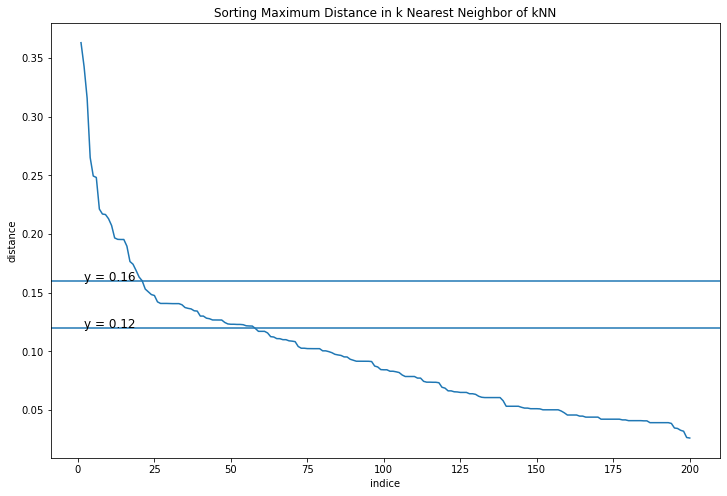

In [ ]:
from sklearn.neighbors import NearestNeighbors


# Xây dựng mô hình k-Means với k=10
neighbors = 10
nbrs = NearestNeighbors(n_neighbors=neighbors ).fit(X_std)

# Ma trận khoảng cách distances: (N, k)
distances, indices = nbrs.kneighbors(X_std)

# Lấy ra khoảng cách xa nhất từ phạm vi láng giềng của mỗi điểm và sắp xếp theo thứ tự giảm dần.
distance_desc = sorted(distances[:, neighbors-1], reverse=True)

# Vẽ biểu đồ khoảng cách xa nhất ở trên theo thứ tự giảm dần
plt.figure(figsize=(12, 8))
plt.plot(list(range(1,len(distance_desc )+1)), distance_desc)
plt.axhline(y=0.12)
plt.text(2, 0.12, 'y = 0.12', fontsize=12)
plt.axhline(y=0.16)
plt.text(2, 0.16, 'y = 0.16', fontsize=12)
plt.ylabel('distance')
plt.xlabel('indice')
plt.title('Sorting Maximum Distance in k Nearest Neighbor of kNN')

Từ biểu đồ k-distance chúng ta có thể thấy điểm `elbow` tương ứng với $\epsilon \in [0.12, 0.16]$. Tiếp theo chúng ta sẽ tìm kiếm giá trị của tham số $\epsilon$ trong khoảng $[0.12, 0.16]$ cho mô hình _DBSCAN_. Tham số `minPts` được cố định là $11$ như lúc đầu lựa chọn và để tương ứng với biểu đồ k-Means.

## 6.2. Xây dựng mô hình DBSCAN

Để xây dựng mô hình _DBSCAN_ trên sklearn chúng ta sử dụng class [sklearn.cluster.DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).

```
DBSCAN(eps=0.5,
 min_samples=5, 
 metric='euclidean', 
 algorithm='auto'
)
```

Trong đó các tham số chính cần quan tâm đó là 

* `eps`: Chính là khoảng cách $\epsilon$ giúp xác định các điểm nằm trong vùng lân cận epsilon. Đây cũng là giá trị khó xác định nhất và tuỳ thuộc vào đặc trưng phân phối của mỗi bộ dữ liệu.

* `min_samples`: Số lượng tối thiểu các điểm láng giềng xung quanh một điểm để xác định một _điểm lõi_, số lượng này đã bao gồm _điểm lõi_. Tương đương với `minPts+1` đã giới thiệu ở trên.

* `metric`: Hàm khoảng cách để đo lường khoảng cách giữa hai điểm bất kì, nhận mặc định là `euclidean`. Hàm khoảng cách và giá trị $\epsilon$ là hai tham số có mối quan hệ chặt chẽ và ảnh hưởng qua lại lẫn nhau và ảnh hưởng lên kết quả phân cụm.

* `algorithm`: Phương pháp được sử dụng để xác định các điểm láng giềng. Bao gồm các phương pháp `auto, ball_tree, kd_tree, brute`. Mặc định là `auto`. Về những phương pháp này bạn có thể tìm hiểu thêm tại [sklearn.neighbors](https://scikit-learn.org/stable/modules/neighbors.html).

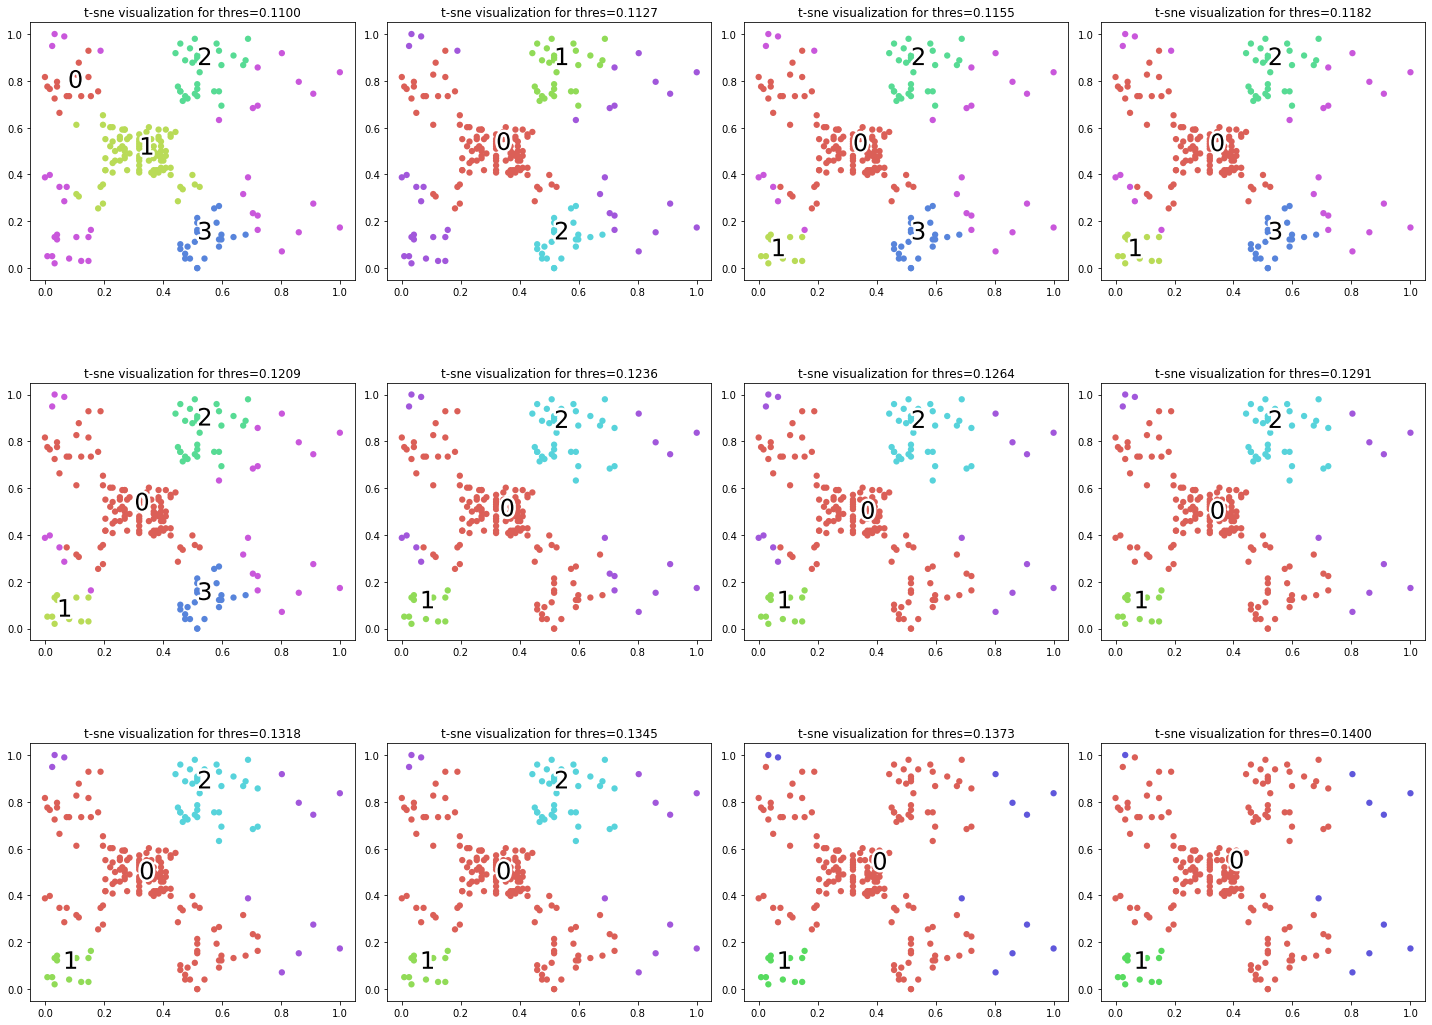

In [ ]:
from matplotlib.gridspec import GridSpec
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

def _plot_kmean_scatter(X, labels, gs, thres):
    '''
    X: dữ liệu đầu vào
    labels: nhãn dự báo
    '''
    # lựa chọn màu sắc
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("hls", num_classes))

    # vẽ biểu đồ scatter
    ax = plt.subplot(gs)
    sc = ax.scatter(X[:,0], X[:,1], lw=0, s=40, c=palette[labels.astype(np.int)])

    # thêm nhãn cho mỗi cluster
    txts = []

    for i in range(num_classes):
        # Vẽ text tên cụm tại trung vị của mỗi cụm
        indices = (labels == i)
        xtext, ytext = np.median(X[indices, :], axis=0)
        if not (np.isnan(xtext) or np.isnan(ytext)):        
            txt = ax.text(xtext, ytext, str(i), fontsize=24)
            txt.set_path_effects([
                PathEffects.Stroke(linewidth=5, foreground="w"),
                PathEffects.Normal()])
            txts.append(txt)
    plt.title('t-sne visualization for thres={:.4f}'.format(thres))

gs = GridSpec(3, 4)
plt.figure(figsize = (25, 18))
plt.subplots_adjust(wspace=0.1,hspace=0.4)

for i, thres in enumerate(np.linspace(0.11, 0.14, 12)):
    dbscan = DBSCAN(eps=thres, min_samples=11, metric='euclidean')
    labels = dbscan.fit_predict(X_std)
    _plot_kmean_scatter(X_std, labels, gs[i], thres)

Giá trị của epsilon ảnh hưởng khá nhạy lên kết quả phân cụm. Căn cứ vào biểu đồ chúng ta có thể lựa chọn $\epsilon = 0.1209$ là giá trị mà các cụm có vẻ mang lại kết quả phân chia tổng quát nhất trên tập dữ liệu huấn luyện. Giá trị này có thể khác biệt theo phương pháp chuẩn hoá dữ liệu và cách lựa chọn trường dữ liệu đầu vào.

# 8. Tổng kết

DBSCAN là một thuật toán đơn giản và hiệu quả. Nó hoạt động dựa trên cách tiếp cận mật độ phân phối của dữ liệu. Ưu điểm của thuật toán đó là có thể tự động loại bỏ được các điểm dữ liệu nhiễu, hoạt động tốt đối với những dữ liệu có hình dạng phân phối đặc thù và có tốc độ tính toán nhanh. Tuy nhiên DBSCAN thường không hiệu quả đối với những dữ liệu có phân phối đều khắp nơi. Khi huấn luyện DBSCAN thì các tham số của mô hình như khoảng cách `epsilon`, số lượng điểm lân cận tối thiểu `minPts` và hàm khoảng cách là những tham số có ảnh hưởng rất lớn đối với kết quả phân cụm. Thực tế cho thấy thuật toán khá nhạy với tham số `epsilon` và `minPts` nên chúng ta cần phải lựa chọn tham số cho mô hình trước khi tiến hành xây dựng mô hình.

# 9. Bài tập

1. Phương pháp phân cụm dựa trên mật độ có nghĩa là gì?
2. Nêu cách xác định điểm lõi, điểm biên và điểm nhiễu trong thuật toán DBSCAN.
3. Quá trình huấn luyện thuật toán DBSCAN diễn ra như thế nào?
4. Thuật toán DBSCAN có ưu điểm hơn so với k-Means clustering là gì?
5. Một bộ dữ liệu có phân phối đặc biệt mà trong đó cụm này bao bọc vòng quanh cụm kia thì thuật toán nào sẽ phù hợp để phân cụm dữ liệu trong các thuật toán k-Means clustering, hierachical clustering và DBSCAN?
6. Thuật toán nào đạt được chi phí toán hiệu quả nhất trong các thuật toán k-Means clustering, hierachical clustering và DBSCAN?
7. Để lựa chọn ra được giá trị `epsilon` phù hợp cho một bộ dữ liệu trước khi huấn luyện mô hình DBSCAN thì phương pháp nào thường được sử dụng?
8. Thông thường thì nên lựa chọn `minPts` như thế nào trong thuật toán DBSCAN?
9. Lấy một bộ dữ liệu bất kì từ nguồn [UCI](https://archive.ics.uci.edu/ml/datasets.php?format=&task=clu&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table) hãy thực hiện huấn luyện một mô hình phân cụm.
10. So sánh kết quả phân cụm với các thuật toán khác như k-Means clustering và hierachical clustering.

# 10. Tài liệu tham khảo

1. https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf

2. https://en.wikipedia.org/wiki/DBSCAN

3. https://www.kdnuggets.com/2020/04/dbscan-clustering-algorithm-machine-learning.html

4. https://towardsdatascience.com/how-dbscan-works-and-why-should-i-use-it-443b4a191c80

5. https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/

6. https://stats.stackexchange.com/questions/88872/a-routine-to-choose-eps-and-minpts-for-dbscan

7. https://www.coursera.org/lecture/predictive-analytics/dbscan-EVHfy

8. https://www.youtube.com/watch?v=6jl9KkmgDIw

9. https://www.youtube.com/watch?v=dGsxd67IFiU